# protein-complex-correlations
6.19.24

Get the Spearman correlations between every pair of proteins in the same complex. 
And then compare to the same procedure but for randomly selected proteins. This
notebook plots all 10 cohorts at once (but takes forever).

In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from Bio import SeqIO
from scipy.stats import spearmanr, ttest_ind #, false_discovery_control 

import matplotlib.pyplot as plt
import seaborn as sns

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette("tab10")

#### Configs

In [2]:
CORUM_df_path="/net/noble/vol2/home/lincolnh/data/humanComplexes.txt"

# The Lupine ensemble imputed matrix
lupine_recon_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-30_DE_sandbox/results/lupine-ensemble-imputed.csv"

# The unimputed joint quants matrix
joint_fname="/net/noble/vol2/home/lincolnh/data/quant-data/UMich-normalized/joint-quants-normalized-shifted.csv"

# The Ensemble (GENCODEv44) fasta
ensembl_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2023-11-13_UMich_dataset/fastas/"
ensembl_df="gencode.v44.pc_translations.fa"

# The HGNC database file
hgnc_database_path="/net/noble/vol2/home/lincolnh/data/quant-data/HGNC_database.txt"

# The handbuilt metadata file
meta_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-10_metadata_mapping/meta-dict.csv"

cohorts=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
         "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]
#cohorts=["BRCA", "CCRCC", "COAD"]

# For the unimputed joint quants matrix
min_pres=18
pres_frac_thresh = 0.5

# For the decoy protein search
rng = np.random.default_rng(seed=18)
# alpha = 0.01

# For plotting
cust_palette = ["#ff7f0e", "#1f77b4", "#2ca02c"]

#### Functions

In [3]:
def get_single_cohort_quants(_meta, _cohort, _recon):
    """
    For a cohort of interest, subset the Lupine imputed joint quants
    matrix down to only runs from the current cohort. We can also use
    this function to remove proteins with greater than 50% initial 
    missingness. 
    
    Parameters
    ----------
    _meta : pandas.DataFrame, 
        The hand built metadata df
    _cohort : str, 
        The cohort of interest
    _recon : pandas.DataFrame, 
        The Lupine imputed joint quants matrix
    
    Returns
    ----------
    recon_cohort : pandas.DataFrame,
        Lupine imputed quants for only the cohort of interest.
    pres_fracs : np.array, 
        A list of the present value fractions for each protein in the
        input matrix. 
    """
    meta_cohort = _meta[_meta["cohort"] == _cohort]
    meta_cohort_nt = meta_cohort[meta_cohort["sample_type"] == "Tumor"]
    #meta_cohort_nt = meta_cohort[meta_cohort["sample_type"] == "Normal"]

    cohort_ids = list(meta_cohort_nt["aliquot_ID"])
    #cohort_ids = list(meta_cohort["aliquot_ID"])

    # Subset the Lupine imputed joint quants matrix
    recon_cohort = _recon[cohort_ids]

    # Get the present value fractions for each protein 
    num_present = np.sum(~np.isnan(recon_cohort), axis=1)
    pres_fracs = num_present / recon_cohort.shape[1]
    
    return recon_cohort, pres_fracs

def run_spearman_correlations(quants):
    """
    Get the correlation between imputed quants for every 
    pair of proteins in the same subunit. We're doing a lot
    of pair-wise comparisons, so this is very slow. 
    
    Parameters
    ----------
    quants : pandas.DataFrame
        The matrix of protein quantifications for imputed
        proteins belonging to the same subunit. 
    
    Returns
    -----------
    corrs, pvals : list, 
        The Spearman correlation coefficients and
        associated p-values, respectively. 
    """
    corrs = []
    pvals = []

    for i in range(0, quants.shape[0]):
        protA = np.array(quants.iloc[i])
        for j in range(0, quants.shape[0]):
            if i == j:
                continue
            protB = np.array(quants.iloc[j])

            corr, pval = spearmanr(protA, protB, nan_policy="omit")
            corrs.append(corr)
            pvals.append(pval)
            
    return corrs, pvals

def bh_correction(_pvals, _alpha=0.05):
    """
    Performs the Benjamini-Hochberg procedure
    for FDR control here, bruh! Returns a boolean
    specifying which p-values to keep per the FDR 
    controlled at the specified threshold. 
    
    Parameters
    ----------
    _pvals : np.ndarray, 
        The sorted list of uncorrected p-values
    _alpha : float, 
        The alpha value 
    
    Returns
    -----------
    keep_arr : list, 
        A boolean list specifying which p-values to
        keep.
    """
    _jstats = []

    for i in range(0, len(_pvals)):
        rank = i + 1
        jstat = (rank * _alpha) / len(_pvals)
        _jstats.append(jstat)

    keep_arr = _jstats > _pvals
    
    return keep_arr

def compare_distributions(_plotter, colA, colB):
    """
    Compares two distributions of correlation coefficients 
    with a paired sample t-test.
    
    Parameters
    ----------
    _plotter : `pandas.DataFrame`, 
        The output/plotting dataframe containing arrays of
        Spearman correlations for w/in complex and decoy
        proteins. 
    colA, colB : str, 
        The names of the two columns in the plotter dataframe
        to compare. 
    
    Returns
    ----------
    pval : float, 
        The p-value. 
    """
    complex_dist = np.array(_plotter[colA])
    decoy_dist = np.array(_plotter[colB])

    nans = np.isnan(complex_dist) | np.isnan(decoy_dist)

    complex_dist_pres = complex_dist[~nans]
    decoy_dist_pres = decoy_dist[~nans]

    tstat, pval = ttest_ind(complex_dist_pres, decoy_dist_pres)
    return pval

#### Read in the CORUM database
This comes from [here](https://mips.helmholtz-muenchen.de/corum/). I think the `subunits(Gene name)` column is what we want. These appear to be HGNC gene IDs.

In [4]:
corum = pd.read_csv(CORUM_df_path, sep="\t")
#corum.head(2)

#### Read in the ensemble imputed Lupine quants
And the associated metadata

In [5]:
lupine_recon = pd.read_csv(lupine_recon_path, index_col=0)
meta = pd.read_csv(meta_path)

#### Map Ensembl protein IDs to Ensembl gene IDs

In [6]:
# Read in the ENSEMBL fasta
ensembl_fasta = ensembl_path + ensembl_df
fasta_seqs = SeqIO.parse(open(ensembl_fasta), "fasta")

# Init both dictionaries
gene_x_prot = {}
prot_x_gene = {}

# Fill in the dictionary 
for fasta in fasta_seqs:
    name, descript, sequence = \
        fasta.id, fasta.description, str(fasta.seq)
    # Get the ENSP and ENSG IDs
    ensp_id = name.split("|")[0]
    ensg_id = name.split("|")[2]
    # Strip the ".x" characters. Hope this is ok.
    ensp_id = ensp_id.split(".")[0]
    ensg_id = ensg_id.split(".")[0]

    # Update the first dictionary
    prot_x_gene[ensp_id] = ensg_id

    # Update the second
    if ensg_id in gene_x_prot:
        gene_x_prot[ensg_id].append(ensp_id)
    else:
        gene_x_prot[ensg_id] = [ensp_id]

#### Init a dataframe to store gene/protein ID mappings

In [7]:
# Read in the HGNC database file
hgnc_db = pd.read_csv(hgnc_database_path, sep="\t")
 
gene_names_df = pd.DataFrame(columns=["ENSP", "ENSG", "HGNC"])
gene_names_df["ENSP"] = lupine_recon.index

/tmp/ipykernel_2343445/1129614679.py:2: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_db = pd.read_csv(hgnc_database_path, sep="\t")


#### Map on the ENSGs and HGNC symbols

In [8]:
# Map the ENSGs to the existing ENSPs
for idx in range(0, gene_names_df.shape[0]):
    curr_row = gene_names_df.iloc[idx]
    curr_ensp = curr_row["ENSP"]
    
    try:
        curr_ensg = prot_x_gene[curr_ensp]
    except KeyError:
        curr_ensg = np.nan

    gene_names_df.loc[idx, "ENSG"] = curr_ensg
    #gene_names_df.iloc[idx]["ENSG"] = curr_ensg
    
    # Add in the HGNC gene ID as well 
    if curr_ensg is not None:
        try:
            hgnc_row = hgnc_db[hgnc_db["ensembl_gene_id"] == curr_ensg]
            hgnc_id = hgnc_row["symbol"].item()

            gene_names_df.loc[idx, "HGNC"] = hgnc_id
            #gene_names_df.iloc[idx]["HGNC"] = hgnc_id
            
        except ValueError:
            pass

### Pre-process the unimputed joint quants matrix

In [9]:
# Read in the joint quants matrix
joint_mat = pd.read_csv(joint_fname, index_col=0)

# Remove some of these extraneous runs
keywords = ["RefInt", "QC", "pool", "Tumor", "Pooled", 
            "Pool", "Reference", "NCI", "NX", "Ref"]
to_drop = []

for sample_id in list(joint_mat.columns):
    exclude=False
    for kw in keywords:
        if kw in sample_id:
            exclude=True
            break
    to_drop.append(exclude)

keep_cols = np.array(joint_mat.columns)[~np.array(to_drop)]
joint_mat = joint_mat[keep_cols]

joint = np.array(joint_mat)

# Remove proteins with too many missing values
num_present = np.sum(~np.isnan(joint), axis=1)
discard = num_present < min_pres
joint = np.delete(joint, discard, axis=0)
keep_prots = np.array(joint_mat.index)[~discard]

unimputed = pd.DataFrame(joint, index=lupine_recon.index, columns=lupine_recon.columns)

#### Replace the Lupine protein IDs with HGNC symbols

In [10]:
lupine_recon.index = gene_names_df["HGNC"]
unimputed.index = gene_names_df["HGNC"]

lupine_recon = lupine_recon.groupby(by=lupine_recon.index, axis=0).mean()
unimputed = unimputed.groupby(by=unimputed.index, axis=0).mean()

print(lupine_recon.shape)
print(unimputed.shape)

/tmp/ipykernel_2343445/2207167163.py:4: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  lupine_recon = lupine_recon.groupby(by=lupine_recon.index, axis=0).mean()
/tmp/ipykernel_2343445/2207167163.py:5: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  unimputed = unimputed.groupby(by=unimputed.index, axis=0).mean()


(14297, 1755)
(14297, 1755)


#### Subset the CORUM database to only complexes for which our joint quants matrix has all subunits

In [11]:
keep_complexes = []

for i in range(0, corum.shape[0]):
    curr = corum.iloc[i]
    curr_subunits = curr["subunits(Gene name)"]
    curr_subunits = curr_subunits.split(";")
    
    keep = True
    for pid in curr_subunits:
        if pid not in list(lupine_recon.index):
            keep = False
            continue
            
    if keep:
        keep_complexes.append(i)

# Subset down
corum_sub = corum.iloc[keep_complexes]
corum_sub = corum_sub.reset_index(drop=True)

#### Generate a simplier df with protein complex and subunit metadata

In [12]:
colnames = ["Complex", "Subunits"]
complex_meta = pd.DataFrame(columns=colnames)

complex_meta["Complex"] = corum_sub["ComplexName"]
complex_meta["Subunits"] = corum_sub["subunits(Gene name)"]

# Remove complexes with only 1 subunit
n_subunits = \
    np.array([len(x.split(";")) for x in complex_meta["Subunits"]])
complex_meta[n_subunits > 1]

complex_meta = complex_meta.reset_index(drop=True)

#### Standardize the metadata `sample_type` labels

In [13]:
for i in range(0, meta.shape[0]):
    curr = meta.iloc[i]
    if curr["sample_type"] == "Primary Tumor":
        meta.iloc[i]["sample_type"] = "Tumor"
    elif curr["sample_type"] == "Solid Tissue Normal":
        meta.iloc[i]["sample_type"] = "Normal"
    elif curr["sample_type"] == "Not Reported":
        meta.iloc[i]["sample_type"] = np.nan
    elif curr["sample_type"] == "Unknown":
        meta.iloc[i]["sample_type"] = np.nan
    elif curr["sample_type"] == "C":
        meta.iloc[i]["sample_type"] = np.nan

/tmp/ipykernel_2343445/3322365204.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  meta.iloc[i]["sample_type"] = "Tumor"
/tmp/ipykernel_2343445/3322365204.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
Y

#### Within-complex Spearman correlations -- Lupine imputed

In [14]:
cohort_corrs = {}

for cohort in cohorts: 
    print(f"working on: {cohort}")

    lupine_recon_cohort, _ = \
        get_single_cohort_quants(meta, cohort, lupine_recon)
    unimputed_cohort, pres_fracs = \
        get_single_cohort_quants(meta, cohort, unimputed)

    # Remove proteins with >50% initial missingness
    lupine_recon_cohort = lupine_recon_cohort[pres_fracs >= pres_frac_thresh]
    
    spearmanr_cohort = []
    print(lupine_recon_cohort.shape)

    for i in tqdm(range(0, complex_meta.shape[0]), unit="complex"):
        curr = complex_meta.iloc[i]
        subunits = curr["Subunits"].split(";")
        subunits_found = np.intersect1d(subunits, list(lupine_recon_cohort.index))
        
        if len(subunits_found) > 1:
            subunit_quants = lupine_recon_cohort.loc[subunits_found]
            corrs, pvals = run_spearman_correlations(subunit_quants)
        else:
            pvals = [np.nan]
            corrs = [np.nan]
            
        pvals = np.array(pvals)
        corrs = np.array(corrs)
        
        spearmanr_cohort.append(corrs)
        
    spearmanr_cohort = np.concatenate(spearmanr_cohort)
    cohort_corrs[cohort] = spearmanr_cohort

working on: BRCA
(9640, 125)


100%|██████████████████████████████| 2997/2997 [01:55<00:00, 26.06complex/s]


working on: CCRCC
(8820, 110)


100%|██████████████████████████████| 2997/2997 [01:42<00:00, 29.20complex/s]


working on: COAD
(6827, 97)


100%|██████████████████████████████| 2997/2997 [01:21<00:00, 36.74complex/s]


working on: GBM
(10141, 100)


100%|██████████████████████████████| 2997/2997 [01:50<00:00, 27.17complex/s]


working on: HGSC
(8222, 84)


100%|██████████████████████████████| 2997/2997 [01:37<00:00, 30.85complex/s]


working on: HNSCC
(9262, 111)


100%|██████████████████████████████| 2997/2997 [01:48<00:00, 27.69complex/s]


working on: LSCC
(10682, 110)


100%|██████████████████████████████| 2997/2997 [01:58<00:00, 25.27complex/s]


working on: LUAD
(10115, 111)


100%|██████████████████████████████| 2997/2997 [01:55<00:00, 25.93complex/s]


working on: PDAC
(8705, 146)


100%|██████████████████████████████| 2997/2997 [01:42<00:00, 29.25complex/s]


working on: UCEC
(9629, 104)


100%|██████████████████████████████| 2997/2997 [01:53<00:00, 26.51complex/s]


#### Random protein correlations -- Lupine imputed

In [15]:
cohort_decoy_corrs = {}

for cohort in cohorts: 
    print(f"working on: {cohort}")

    lupine_recon_cohort, _ = get_single_cohort_quants(meta, cohort, lupine_recon)
    unimputed_cohort, pres_fracs = get_single_cohort_quants(meta, cohort, unimputed)
    
    # Remove proteins with >50% initial missingness
    lupine_recon_cohort = lupine_recon_cohort[pres_fracs >= pres_frac_thresh]

    spearmanr_cohort_decoy = []
    print(lupine_recon_cohort.shape)

    for i in tqdm(range(0, complex_meta.shape[0]), unit="complex"):
        curr = complex_meta.iloc[i]
        subunits = curr["Subunits"].split(";")
        n_subunits = len(subunits)

        idxs = rng.integers(
                    low=0, 
                    high=lupine_recon_cohort.shape[0], 
                    size=n_subunits,
        )
        subunit_quants = lupine_recon_cohort.iloc[idxs]
        corrs, pvals = run_spearman_correlations(subunit_quants)

        pvals = np.array(pvals)
        corrs = np.array(corrs)

        spearmanr_cohort_decoy.append(corrs)
        
    spearmanr_cohort_decoy = np.concatenate(spearmanr_cohort_decoy)
    cohort_decoy_corrs[cohort] = spearmanr_cohort_decoy

working on: BRCA
(9640, 125)


100%|██████████████████████████████| 2997/2997 [01:53<00:00, 26.52complex/s]


working on: CCRCC
(8820, 110)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.58complex/s]


working on: COAD
(6827, 97)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.66complex/s]


working on: GBM
(10141, 100)


100%|██████████████████████████████| 2997/2997 [01:51<00:00, 26.79complex/s]


working on: HGSC
(8222, 84)


100%|██████████████████████████████| 2997/2997 [01:50<00:00, 27.12complex/s]


working on: HNSCC
(9262, 111)


100%|██████████████████████████████| 2997/2997 [01:50<00:00, 27.08complex/s]


working on: LSCC
(10682, 110)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.73complex/s]


working on: LUAD
(10115, 111)


100%|██████████████████████████████| 2997/2997 [01:50<00:00, 27.14complex/s]


working on: PDAC
(8705, 146)


100%|██████████████████████████████| 2997/2997 [01:51<00:00, 26.83complex/s]


working on: UCEC
(9629, 104)


100%|██████████████████████████████| 2997/2997 [01:50<00:00, 27.19complex/s]


#### Within complex correlations -- unimputed

In [16]:
cohort_corrs_unimputed = {}

for cohort in cohorts: 
    print(f"working on: {cohort}")

    unimputed_cohort, pres_fracs = \
        get_single_cohort_quants(meta, cohort, unimputed)

    # Remove proteins with >50% initial missingness
    unimputed_cohort = unimputed_cohort[pres_fracs >= pres_frac_thresh]

    spearmanr_cohort = []
    print(unimputed_cohort.shape)

    for i in tqdm(range(0, complex_meta.shape[0]), unit="complex"):
        curr = complex_meta.iloc[i]
        subunits = curr["Subunits"].split(";")

        subunits_found = np.intersect1d(subunits, list(lupine_recon_cohort.index))
        if len(subunits_found) > 1:
            subunit_quants = lupine_recon_cohort.loc[subunits_found]
            corrs, pvals = run_spearman_correlations(subunit_quants)
        else:
            pvals = [np.nan]
            corrs = [np.nan]

        pvals = np.array(pvals)
        corrs = np.array(corrs)
        
        spearmanr_cohort.append(corrs)
        
    spearmanr_cohort = np.concatenate(spearmanr_cohort)
    cohort_corrs_unimputed[cohort] = spearmanr_cohort

working on: BRCA
(9640, 125)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.71complex/s]


working on: CCRCC
(8820, 110)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.61complex/s]


working on: COAD
(6827, 97)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.70complex/s]


working on: GBM
(10141, 100)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.69complex/s]


working on: HGSC
(8222, 84)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.67complex/s]


working on: HNSCC
(9262, 111)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.68complex/s]


working on: LSCC
(10682, 110)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.68complex/s]


working on: LUAD
(10115, 111)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.70complex/s]


working on: PDAC
(8705, 146)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.66complex/s]


working on: UCEC
(9629, 104)


100%|██████████████████████████████| 2997/2997 [01:52<00:00, 26.67complex/s]


#### Non-complex protein correlations -- unimputed

In [17]:
cohort_decoy_corrs_unimputed = {}

for cohort in cohorts: 
    print(f"working on: {cohort}")

    unimputed_cohort, pres_fracs = get_single_cohort_quants(meta, cohort, unimputed)
    spearmanr_cohort_decoy = []

    # Remove proteins with >50% initial missingness
    unimputed_cohort = unimputed_cohort[pres_fracs >= pres_frac_thresh]
    print(unimputed_cohort.shape)

    for i in tqdm(range(0, complex_meta.shape[0]), unit="complex"):
        curr = complex_meta.iloc[i]
        subunits = curr["Subunits"].split(";")
        n_subunits = len(subunits)

        idxs = rng.integers(
                    low=0, 
                    high=unimputed_cohort.shape[0], 
                    size=n_subunits,
        )
        subunit_quants = unimputed_cohort.iloc[idxs]
        try:
            corrs, pvals = run_spearman_correlations(subunit_quants)
        except ValueError:
            corrs = [np.nan]
            pvals = [np.nan]

        pvals = np.array(pvals)
        corrs = np.array(corrs)

        spearmanr_cohort_decoy.append(corrs)
        
    spearmanr_cohort_decoy = np.concatenate(spearmanr_cohort_decoy)
    cohort_decoy_corrs_unimputed[cohort] = spearmanr_cohort_decoy

working on: BRCA
(9640, 125)


100%|██████████████████████████████| 2997/2997 [01:56<00:00, 25.65complex/s]


working on: CCRCC
(8820, 110)


100%|██████████████████████████████| 2997/2997 [01:57<00:00, 25.57complex/s]


working on: COAD
(6827, 97)


100%|██████████████████████████████| 2997/2997 [01:58<00:00, 25.32complex/s]


working on: GBM
(10141, 100)


100%|██████████████████████████████| 2997/2997 [01:56<00:00, 25.82complex/s]


working on: HGSC
(8222, 84)


100%|██████████████████████████████| 2997/2997 [01:56<00:00, 25.81complex/s]


working on: HNSCC
(9262, 111)


100%|██████████████████████████████| 2997/2997 [01:56<00:00, 25.70complex/s]


working on: LSCC
(10682, 110)


100%|██████████████████████████████| 2997/2997 [01:56<00:00, 25.65complex/s]


working on: LUAD
(10115, 111)


100%|██████████████████████████████| 2997/2997 [01:56<00:00, 25.71complex/s]


working on: PDAC
(8705, 146)


100%|██████████████████████████████| 2997/2997 [01:59<00:00, 25.14complex/s]


working on: UCEC
(9629, 104)


100%|██████████████████████████████| 2997/2997 [01:57<00:00, 25.45complex/s]


#### Standardize the lengths of the vectors
These are different because we're using a significance threshold to determine which 
pvals to keep. There's no guarentee that the same number of comparisons will pass the significance threshold every time. 

In [18]:
lens1 = [len(x) for x in cohort_corrs.values()]
lens2 = [len(x) for x in cohort_decoy_corrs.values()]
lens3 = [len(x) for x in cohort_corrs_unimputed.values()]
lens4 = [len(x) for x in cohort_decoy_corrs_unimputed.values()]
max_len = np.max([lens1, lens2, lens3, lens4])

# Add padding for the protein complex correlations
for key in cohort_corrs.keys():
    vec = cohort_corrs[key]
    toadd = max_len - len(vec)
    pad = np.zeros(toadd)
    pad[:] = np.nan
    new_vec = np.concatenate([vec, pad])
    cohort_corrs[key] = new_vec

# Add padding for the decoy protein correlations 
for key in cohort_decoy_corrs.keys():
    vec = cohort_decoy_corrs[key]
    toadd = max_len - len(vec)
    pad = np.zeros(toadd)
    pad[:] = np.nan
    new_vec = np.concatenate([vec, pad])
    cohort_decoy_corrs[key] = new_vec

# And for the unimputed complex correlations 
for key in cohort_corrs_unimputed.keys():
    vec = cohort_corrs_unimputed[key]
    toadd = max_len - len(vec)
    pad = np.zeros(toadd)
    pad[:] = np.nan
    new_vec = np.concatenate([vec, pad])
    cohort_corrs_unimputed[key] = new_vec

# Finally, for the unimputed decoy protein correlations 
for key in cohort_decoy_corrs_unimputed.keys():
    vec = cohort_decoy_corrs_unimputed[key]
    toadd = max_len - len(vec)
    pad = np.zeros(toadd)
    pad[:] = np.nan
    new_vec = np.concatenate([vec, pad])
    cohort_decoy_corrs_unimputed[key] = new_vec

#### Generate a dataframe for plotting
Lol this could be better. 

In [19]:
cols=["BRCA_complex_lupine", "BRCA_complex_unimputed", "BRCA_random_lupine", "BRCA_random_unimputed",
      "CCRCC_complex_lupine", "CCRCC_complex_unimputed", "CCRCC_random_lupine", "CCRCC_random_unimputed",
      "COAD_complex_lupine","COAD_complex_unimputed", "COAD_random_lupine", "COAD_random_unimputed",
      "GBM_complex_lupine", "GBM_complex_unimputed", "GBM_random_lupine", "GBM_random_unimputed",
      "HGSC_complex_lupine", "HGSC_complex_unimputed", "HGSC_random_lupine", "HGSC_random_unimputed",
      "HNSCC_complex_lupine", "HNSCC_complex_unimputed", "HNSCC_random_lupine", "HNSCC_random_unimputed",
      "LSCC_complex_lupine", "LSCC_complex_unimputed",  "LSCC_random_lupine", "LSCC_random_unimputed",
      "LUAD_complex_lupine", "LUAD_complex_unimputed", "LUAD_random_lupine", "LUAD_random_unimputed",
      "PDAC_complex_lupine", "PDAC_complex_unimputed", "PDAC_random_lupine", "PDAC_random_unimputed",
      "UCEC_complex_lupine", "UCEC_complex_unimputed", "UCEC_random_lupine", "UCEC_random_unimputed",
]
plotter = pd.DataFrame(columns=cols)

plotter["BRCA_complex_lupine"] = cohort_corrs["BRCA"]
plotter["BRCA_complex_unimputed"] = cohort_corrs_unimputed["BRCA"]
plotter["BRCA_random_lupine"] = cohort_decoy_corrs["BRCA"]
plotter["BRCA_random_unimputed"] = cohort_decoy_corrs_unimputed["BRCA"]

plotter["CCRCC_complex_lupine"] = cohort_corrs["CCRCC"]
plotter["CCRCC_complex_unimputed"] = cohort_corrs_unimputed["CCRCC"]
plotter["CCRCC_random_lupine"] = cohort_decoy_corrs["CCRCC"]
plotter["CCRCC_random_unimputed"] = cohort_decoy_corrs_unimputed["CCRCC"]

plotter["COAD_complex_lupine"] = cohort_corrs["COAD"]
plotter["COAD_complex_unimputed"] = cohort_corrs_unimputed["COAD"]
plotter["COAD_random_lupine"] = cohort_decoy_corrs["COAD"]
plotter["COAD_random_unimputed"] = cohort_decoy_corrs_unimputed["COAD"]

plotter["GBM_complex_lupine"] = cohort_corrs["GBM"]
plotter["GBM_complex_unimputed"] = cohort_corrs_unimputed["GBM"]
plotter["GBM_random_lupine"] = cohort_decoy_corrs["GBM"]
plotter["GBM_random_unimputed"] = cohort_decoy_corrs_unimputed["GBM"]

plotter["HGSC_complex_lupine"] = cohort_corrs["HGSC"]
plotter["HGSC_complex_unimputed"] = cohort_corrs_unimputed["HGSC"]
plotter["HGSC_random_lupine"] = cohort_decoy_corrs["HGSC"]
plotter["HGSC_random_unimputed"] = cohort_decoy_corrs_unimputed["HGSC"]

plotter["HNSCC_complex_lupine"] = cohort_corrs["HNSCC"]
plotter["HNSCC_complex_unimputed"] = cohort_corrs_unimputed["HNSCC"]
plotter["HNSCC_random_lupine"] = cohort_decoy_corrs["HNSCC"]
plotter["HNSCC_random_unimputed"] = cohort_decoy_corrs_unimputed["HNSCC"]

plotter["LSCC_complex_lupine"] = cohort_corrs["LSCC"]
plotter["LSCC_complex_unimputed"] = cohort_corrs_unimputed["LSCC"]
plotter["LSCC_random_lupine"] = cohort_decoy_corrs["LSCC"]
plotter["LSCC_random_unimputed"] = cohort_decoy_corrs_unimputed["LSCC"]

plotter["LUAD_complex_lupine"] = cohort_corrs["LUAD"]
plotter["LUAD_complex_unimputed"] = cohort_corrs_unimputed["LUAD"]
plotter["LUAD_random_lupine"] = cohort_decoy_corrs["LUAD"]
plotter["LUAD_random_unimputed"] = cohort_decoy_corrs_unimputed["LUAD"]

plotter["PDAC_complex_lupine"] = cohort_corrs["PDAC"]
plotter["PDAC_complex_unimputed"] = cohort_corrs_unimputed["PDAC"]
plotter["PDAC_random_lupine"] = cohort_decoy_corrs["PDAC"]
plotter["PDAC_random_unimputed"] = cohort_decoy_corrs_unimputed["PDAC"]

plotter["UCEC_complex_lupine"] = cohort_corrs["UCEC"]
plotter["UCEC_complex_unimputed"] = cohort_corrs_unimputed["UCEC"]
plotter["UCEC_random_lupine"] = cohort_decoy_corrs["UCEC"]
plotter["UCEC_random_unimputed"] = cohort_decoy_corrs_unimputed["UCEC"]

#### Do some wrangling

In [20]:
plotter_melt = plotter.melt()

cohort = [x.split("_")[0] for x in plotter_melt["variable"]]
condition = [x.split("_")[1] for x in plotter_melt["variable"]]
method = [x.split("_")[2] for x in plotter_melt["variable"]]

plotter_melt["cohort"] = cohort
plotter_melt["condition"] = condition
plotter_melt["method"] = method

plotter_melt = plotter_melt.rename(columns={"value":"corr"})
plotter_melt = plotter_melt.drop(columns=["variable"])

joint_strs = plotter_melt["condition"] + "_" + plotter_melt["method"]
plotter_melt["joint_vars"] = joint_strs

#### Can I come up with a better legend labeling scheme? 

In [21]:
sub0 = plotter_melt[plotter_melt["joint_vars"] == "complex_lupine"]
sub0_idx = np.array(sub0.index)
plotter_melt.loc[sub0_idx, "label"] = "Lupine Complex"

sub1 = plotter_melt[plotter_melt["joint_vars"] == "random_lupine"]
sub1_idx = np.array(sub1.index)
plotter_melt.loc[sub1_idx, "label"] = "Lupine Random"

sub2 = plotter_melt[plotter_melt["joint_vars"] == "complex_unimputed"]
sub2_idx = np.array(sub2.index)
plotter_melt.loc[sub2_idx, "label"] = "Unimputed Complex"

sub3 = plotter_melt[plotter_melt["joint_vars"] == "random_unimputed"]
sub3_idx = np.array(sub3.index)
plotter_melt.loc[sub3_idx, "label"] = "Unimputed Random"

#### Generate grouped box plot

In [22]:
pal = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]

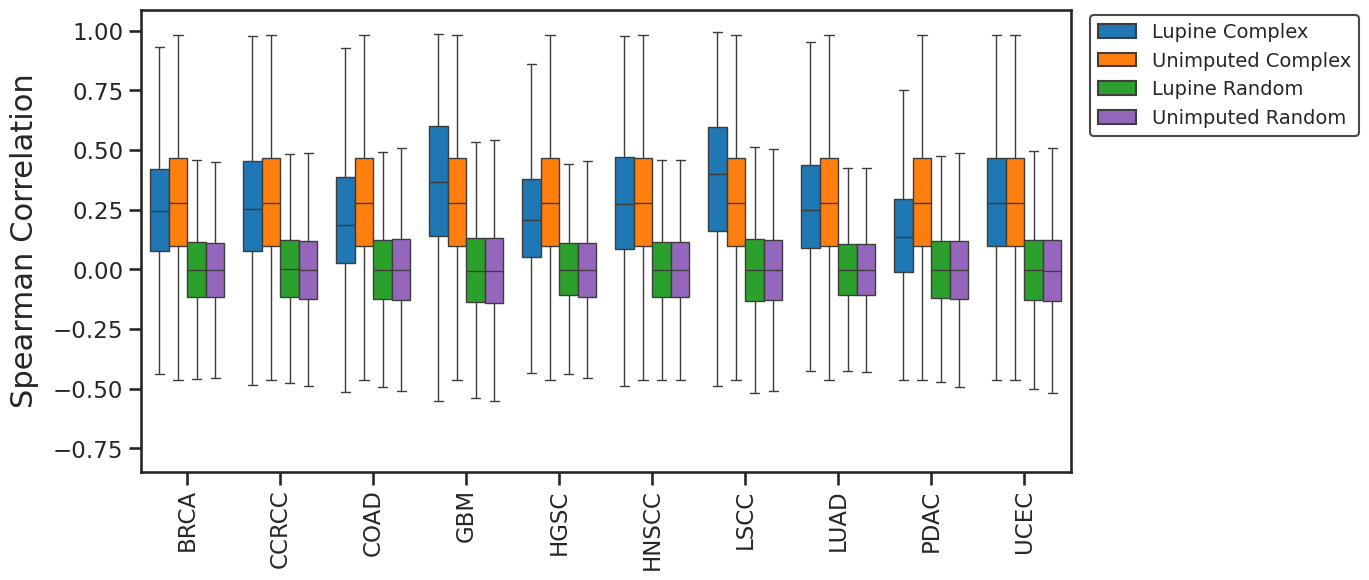

In [23]:
plt.figure(figsize=(12,6))

ax = sns.boxplot(
        data=plotter_melt, 
        x="cohort", 
        y="corr", 
        hue="label", 
        palette=pal,
        saturation=1.0,
        fliersize=0,
)
ax.set_xlabel("")
ax.set_ylabel("Spearman Correlation", labelpad=10, size=22)
ax.legend(title="", edgecolor="k", prop={'size': 14}, bbox_to_anchor=(1.01, 1.01))
ax.tick_params(axis='x', labelrotation=90)

plt.show()
#plt.savefig("../figures/protein-complex-correlations-v2.pdf", bbox_inches="tight")

#### Get p-values for each pair of Lupine imputed complex/decoy proteins

In [24]:
brca_pval = compare_distributions(plotter, "BRCA_complex_lupine", "BRCA_random_lupine")
ccrcc_pval = compare_distributions(plotter, "CCRCC_complex_lupine", "CCRCC_random_lupine")
coad_pval = compare_distributions(plotter, "COAD_complex_lupine", "COAD_random_lupine")
gbm_pval = compare_distributions(plotter, "GBM_complex_lupine", "GBM_random_lupine")
hgsc_pval = compare_distributions(plotter, "HGSC_complex_lupine", "HGSC_random_lupine")
hnscc_pval = compare_distributions(plotter, "HNSCC_complex_lupine", "HNSCC_random_lupine")
lscc_pval = compare_distributions(plotter, "LSCC_complex_lupine", "LSCC_random_lupine")
luad_pval = compare_distributions(plotter, "LUAD_complex_lupine", "LUAD_random_lupine")
pdac_pval = compare_distributions(plotter, "PDAC_complex_lupine", "PDAC_random_lupine")
ucec_pval = compare_distributions(plotter, "UCEC_complex_lupine", "UCEC_random_lupine")

pvals_list = [brca_pval, ccrcc_pval, coad_pval, gbm_pval, hgsc_pval, 
              hnscc_pval, lscc_pval, luad_pval, pdac_pval, ucec_pval]

print(brca_pval)
print(ccrcc_pval)
print(coad_pval)
print(gbm_pval)
print(hgsc_pval)
print(hnscc_pval)
print(lscc_pval)
print(luad_pval)
print(pdac_pval)
print(ucec_pval)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


#### Get the means and standard deviations (Lupine imputed)

In [25]:
complex_cols = ["BRCA_complex_lupine", "CCRCC_complex_lupine", "COAD_complex_lupine", 
                "GBM_complex_lupine", "HGSC_complex_lupine", "HNSCC_complex_lupine", 
                "LSCC_complex_lupine", "LUAD_complex_lupine", "PDAC_complex_lupine", 
                "UCEC_complex_lupine"]
noncomplex_cols = ["BRCA_random_lupine", "CCRCC_random_lupine", "COAD_random_lupine", 
                   "GBM_random_lupine", "HGSC_random_lupine", "HNSCC_random_lupine", 
                   "LSCC_random_lupine", "LUAD_random_lupine", "PDAC_random_lupine", 
                   "UCEC_random_lupine"]

complex_corrs = []
noncomplex_corrs = []

for col in complex_cols:
    curr = list(plotter[col])
    complex_corrs = complex_corrs + curr

for col in noncomplex_cols:
    curr = list(plotter[col])
    noncomplex_corrs = noncomplex_corrs + curr

print(np.nanmean(complex_corrs))
print(np.mean(noncomplex_corrs))

0.2695146758955576
0.002796947264643108


#### Repeat, for unimputed quants

In [26]:
complex_cols = ["BRCA_complex_unimputed", "CCRCC_complex_unimputed", "COAD_complex_unimputed", 
                "GBM_complex_unimputed", "HGSC_complex_unimputed", "HNSCC_complex_unimputed", 
                "LSCC_complex_unimputed", "LUAD_complex_unimputed", "PDAC_complex_unimputed", 
                "UCEC_complex_unimputed"]
noncomplex_cols = ["BRCA_random_unimputed", "CCRCC_random_unimputed", "COAD_random_unimputed", 
                   "GBM_random_unimputed", "HGSC_random_unimputed", "HNSCC_random_unimputed", 
                   "LSCC_random_unimputed", "LUAD_random_unimputed", "PDAC_random_unimputed", 
                   "UCEC_random_unimputed"]

complex_corrs = []
noncomplex_corrs = []

for col in complex_cols:
    curr = list(plotter[col])
    complex_corrs = complex_corrs + curr

for col in noncomplex_cols:
    curr = list(plotter[col])
    noncomplex_corrs = noncomplex_corrs + curr

print(np.nanmean(complex_corrs))
print(np.mean(noncomplex_corrs))

0.28369178497724484
0.0013444325226135852
